# SpGRUModel Demo

## Install and Include programs and modules

In [18]:
import pandas
from matplotlib.pyplot import plot,stem
from numpy import append,sin,pi,linspace

In [8]:
# %load SpGRUModelTorch.py
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
SPGRUMODEL GRU based sparse signal model
   Code by Fredy Vides
   For Paper, "Computing Sparse Autoencoders and Autoregressors for Signal Identification"
   by F. Vides
@author: Fredy Vides
"""
def SpGRUModelTorch(data,Lag,sp,N,ep,spp = 0.1):
    import torch
    import torch.nn as nn
    import numpy as np
    from numpy import reshape
    from scipy.linalg import hankel
    
    md = data.min()
    
    Md = abs(data - md).max()
    
    data = (data-md)/Md
    
    L = int(len(data) * sp)
    
    xt = data[:L]
    
    H = hankel(xt[:Lag],xt[(Lag-1):]).T
    Xt = H[:-1,:]
    Yt = H[1:,-1]
    
    Xtt = []
    Ytt = []
    for k in range(Xt.shape[0]-1):
        Xtt.append(torch.FloatTensor(reshape(Xt[k],(1,1,Lag))))
        Ytt.append(torch.FloatTensor(reshape(Yt[k],(1,1))))
     
    class GRU(nn.Module):
        def __init__(self, num_classes, input_size, hidden_size, num_layers):
            super(GRU, self).__init__()
            self.num_classes = num_classes
            self.num_layers = num_layers
            self.input_size = input_size
            self.hidden_size = hidden_size
           
            self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
            self.linear = nn.Linear(hidden_size, num_classes)
        
        def forward(self, x):
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  
            _, h_out = self.gru(x, h_0)
            h_out = h_out.view(-1, self.hidden_size)
            out = self.linear(h_out)   
            return out
    
    model = GRU(1,Lag,N,1)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=spp)
    
    error = 1.0
    i = 0
    while i <= ep and error>10*spp:
        for k in range(len(Ytt)):
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
            y_pred = model(Xtt[k])
            single_loss = loss_function(y_pred, Ytt[k])
            single_loss.backward()
            optimizer.step()
        error = single_loss.item()
    
    h = data[:Lag]
    
    return model,H,h

In [ ]:
# %load SpGRUPredictorTorch.py
# Example: python3 LSTMTSModel.py '../DataSets/signal_with_anomaly.csv' 300 20 3400 0.15 16
# Example: runfile("LSTMTSModel.py","'../DataSets/signal_with_anomaly.csv' 300 20 3400 0.15 16")
# Example: runfile("LSTMTSModel.py","'../DataSets/signal_with_anomaly.csv' 30 60 880 0.1 16")
import sys
"""
Created on Wed Mar 31 02:57:52 2021
SPGRUPREDICTOR GRU based sparse predictor
   Code by Fredy Vides
   For Paper, "Computing Sparse Autoencoders and Autoregressors for Signal Identification"
   by F. Vides
@author: Fredy Vides
"""
def SpGRUPredictorTorch(data,model,h,N):
    from numpy import append,reshape
    from torch import FloatTensor
    Lag = len(h)
    md = data.min()
    Md = abs(data - md).max()
    X = []
    x0 = []
    X = h
    x0 = FloatTensor(reshape(h,(1,1,Lag)))
    for j in range(N):
        x = model(x0)
        xc = x0.clone()
        x0[0][0][:-1] = xc[0][0][1:]
        x0[0][0][-1]=x.detach()
        X = append(X,x.detach().numpy()[0][0])
    X = append(data[0],Md*X+md)
    return X

In [ ]:
# %load LagEstimate.py
#!/usr/bin/env python3
"""
Created on Thu Sep  2 17:31:47 2021
Created on Wed Mar 31 02:57:52 2021
DFTSPSOLVER DFT based sparse linear regression solver
   Code by Fredy Vides
   For Paper, "Computing Sparse Autoencoders and Autoregressors for Signal Identification"
   by F. Vides
@author: Fredy Vides
@author: doctor
"""
def LagEstimate(data,L0):
    from statsmodels.tsa.stattools import acf 
    from scipy.signal import find_peaks
    from numpy import where
    L = acf(data,adjusted=False,nlags=len(data),fft=True)
    p = find_peaks(L)
    q=where(L[p[0]]==L[p[0]].max())
    L = max(p[0][q[0][0]],L0)
    return L

## Setup some parameters

In [22]:
t = linspace(0,10,1001)
data = sin(2*pi*t)
Lag = LagEstimate(data,10)
sp = 0.2
nn = 16
ep = 60
md = data.min()
Md = abs(data - md).max()
N = 900
spp = 1e-5

## Compute model

In [23]:
TS_Model,H,h = SpGRUModelTorch(data,Lag,sp,nn,ep,spp)

## Compute predictions

In [24]:
X = SpGRUPredictorTorch(data,TS_Model,h,N)

## Plot predictions

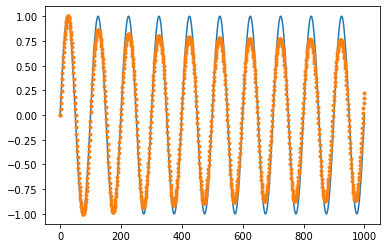

In [25]:
plot(data[:len(X)]),plot(X,'.');

## Get Weights

In [26]:
print(TS_Model)

GRU(
  (gru): GRU(100, 16, batch_first=True)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)


<StemContainer object of 3 artists>

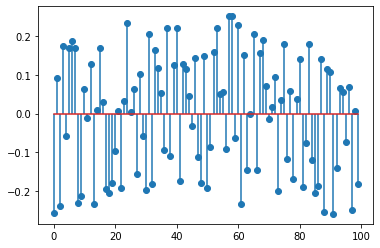

In [27]:
W = TS_Model.gru.weight_ih_l0
stem(W[0,:].detach())

## Compare to Linear Model Component

In [28]:
from numpy import sin,pi,linspace,append,ceil,fliplr,roots,array,reshape,zeros,real,imag
import matplotlib.pyplot as plt

In [10]:
# %load lsspsolver.py
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
LSSPSOLVER  Sparse linear least squares solver
   Code by Fredy Vides
   For Paper, "Computing sparse autoencoders and autoregressors for signal
   identification"
   by F. Vides
@author: Fredy Vides
"""

def lsspsolver(A,Y,L=100,tol=1e-2,delta=1e-2):
    from numpy.linalg import svd,lstsq,norm
    from numpy import zeros,dot,diag,argsort,sort,inf
    N=A.shape[1]
    X=zeros((N,))
    u,s,v=svd(A,full_matrices=0)
    rk=sum(s>tol)
    u=u[:,:rk]
    s=s[:rk]
    s=1/s
    s=diag(s)
    v=v[:rk,:]
    A=dot(u.T,A)
    Y=dot(u.T,Y)
    X0=dot(v.T,dot(s,Y))
    w=zeros((N,))
    K=1
    Error=1+tol
    c=X0
    x0=c
    ac=abs(c)
    f=argsort(-ac)
    N0=max(sum(ac[f]>delta),1)
    while (K<=L) & (Error>tol):
        ff=f[:N0]
        X=w
        c, res, rnk, s = lstsq(A[:,ff],Y,rcond=None)
        X[ff]=c
        Error=norm(x0-X[:],inf)
        x0=X
        ac=abs(x0)
        f=argsort(-ac)
        N0=max(sum(ac[f]>delta),1)
        K=K+1
    return X

In [32]:
# %load SpAutoRegressor.py
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
SPAUTOREGRESSOR  Sparse autoregressor for time series modeling
   Code by Fredy Vides
   For Paper, "Computing sparse autoencoders and autoregressors for signal
   modeling"
   by F. Vides
@author: Fredy Vides

 Example:
     
 from pandas import read_csv
 from SpAutoRegressor import SpAutoRegressor
 from SPARPredictor import SPARPredictor
 from LagEstimate import LagEstimate
 from numpy import ceil
 import matplotlib.pyplot as plt
 data = read_csv('../DataSets/signal_with_anomaly.csv', usecols=[1], engine='python')
 x = data.values
 mx = x.min()
 Mx = abs(x-mx).max()
 xs = 2*(x-mx)/Mx-1
 sampling_proportion = 0.3
 L0 = int(ceil(sampling_proportion*len(xs)))
 Lag = LagEstimate(xs[:L0],1)
 steps = 2400
 A,h = SpAutoRegressor(xs,1/len(xs),sampling_proportion,1,Lag,1e-1,1e-1)
 y = Mx*(SPARPredictor(A,h,steps)+1)/2+mx
 plt.plot(x[(L0-Lag):L0+steps,0]),plt.plot(y)
 plt.show()
 plt.stem(A)

 from numpy import sin,pi,arange,append,ceil
 import matplotlib.pyplot as plt
 from SpAutoRegressor import SpAutoRegressor
 from SPARPredictor import SPARPredictor
 from LagEstimate import LagEstimate
 t = arange(0,10,.01)
 t = append(t,10)
 x = sin(2*pi*t)
 mx = x.min()
 Mx = abs(x-mx).max()
 xs = 2*(x-mx)/Mx-1
 sampling_proportion = 0.2
 L0 = int(ceil(sampling_proportion*len(xs)))
 Lag = LagEstimate(xs[:L0],1)
 steps = 800
 A,h = SpAutoRegressor(xs,1/len(xs),sampling_proportion,1,Lag,1e-1,1e-1)
 y = Mx*(SPARPredictor(A,h,steps)+1)/2+mx
 L0 = int(ceil(sampling_proportion*len(xs)))
 plt.plot(x[(L0-Lag):L0+steps]),plt.plot(y)
 plt.show()
 plt.stem(A)
"""
def SpAutoRegressor(x,ssp,sp,pp,L0,tol,delta):
    from numpy import ceil,floor,max,min,asmatrix
    from scipy.linalg import hankel
    sl = len(x)
    ssp=int(ceil(sl*ssp))
    x = x[0:sl:ssp]
    sl = len(x)
    sp = int(ceil(sp*sl))
    xt = x[:sp]
    pp = max([min([floor(pp*sp),sl-sp]),L0])
    xl = x[(sp+1):]
    L=L0
    H=hankel(xt[:L],xt[(L-1):])
    Lh=H.shape[1]
    H0=H[:,:(Lh-1)]
    H1=H[L-1,1:Lh]
    A = lsspsolver(H0.T,H1.T,L,tol,delta)
    return A.T,H1[Lh-L-1:Lh]

In [33]:
# %load SPARPredictor.py
#!/usr/bin/env python3
"""
Created on Thu Aug 26 01:06:38 2021

@author: doctor
"""

def SPARPredictor(A,h,N):
    from numpy import arange,append
    y=h
    L = len(h)
    for k in arange(N):
        y = append(y,A.dot(h))
        h = y[k+1:L+k+1]
    return y

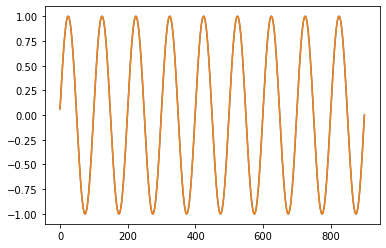

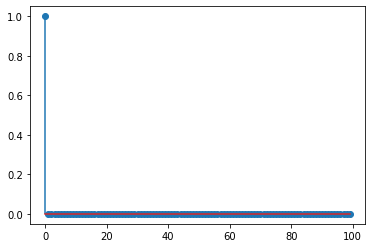

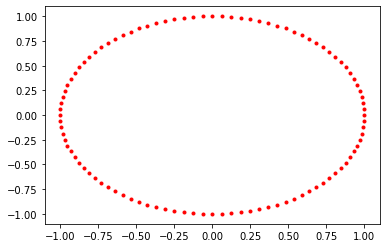

In [34]:
from numpy import ceil
t = linspace(0,10,1001)
t = append(t,10)
x = sin(2*pi*t)
mx = x.min()
Mx = abs(x-mx).max()
xs = 2*(x-mx)/Mx-1
sampling_proportion = 0.2
L0 = int(ceil(sampling_proportion*len(xs)))
Lag = LagEstimate(xs[:L0],1)
steps = 800
A,h = SpAutoRegressor(xs,1/len(xs),sampling_proportion,1,Lag,1e-1,1e-1)
y = Mx*(SPARPredictor(A,h,steps)+1)/2+mx
L0 = int(ceil(sampling_proportion*len(xs)))
plt.plot(x[(L0-Lag):L0+steps]),plt.plot(y)
plt.show()
plt.stem(A)
plt.show()
A = reshape(A,(1,len(A)))
p = zeros((1,A.shape[1]+1))
p[0,0] = 1
p[0,1:] = -fliplr(A)
r = roots(reshape(p,(p.shape[1],)))
plt.plot(real(r),imag(r),'r.')